In [7]:
%matplotlib inline

In [8]:
import argparse
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial.distance

import torch
import cpc.feature_loader as fl
import cpc.train as tr
from cpc.dataset import AudioBatchData, findAllSeqs, filterSeqs, parseSeqLabels
import torch.nn.functional as F
from cpc.criterion.seq_alignment import collapseLabelChain

In [9]:
sys.path.append(os.path.dirname(tr.__file__))

In [10]:
CP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/acpc-baseline-cosine/checkpoint_49.pt'

In [11]:
cdata = fl.getCheckpointData(os.path.dirname(CP))
_, _, args = cdata
model, args.hiddenGar, args.hiddenEncoder = fl.loadModel([CP])
assert args.speakerEmbedding == 0

try:
    criterion = tr.loadCriterion(CP, model.gEncoder.DOWNSAMPLING, len(speakers), None)
except:
    criterion = None
    print("Failed to load criterion :(((())))")

Loading checkpoint /pio/scratch/1/i323106/wav2vec/runs/cpc/acpc-baseline-cosine/checkpoint_49.pt
LocArgs: Namespace(CPCCTC=True, CPCCTCLearnBlank=False, CPCCTCLossTemp=1.0, CPCCTCMasq='', CPCCTCNoNegsMatchWin=False, CPCCTCNormalizeEncs=False, CPCCTCNormalizePreds=False, CPCCTCNumLevels=1, CPCCTCNumMatched=12, CPCCTCReductionFactor=4, CPCCTCSelfLoop=False, CPCCTCSkipBeg=0, CPCCTCSkipEnd=0, CTC=False, CTCphones=False, abspos=False, arMode='LSTM', batchSizeGPU=32, beta1=0.9, beta2=0.999, captureCPCCTCalign=False, captureCPCCTClogScores=False, captureConvRepr=False, captureCtxRepr=False, captureDSfreq=None, captureDStotNr=None, captureEachEpochs=10, captureEverything=False, capturePhoneAlign=False, capturePred=False, captureSetStats=None, captureSpeakerAlign=False, cpc_mode=None, debug=False, dropout=True, encodeSegments=False, encoder_type='cpc', epsilon=1e-08, file_extension='.flac', gru_level=-1, headWeights=[1.0, 1.0], hiddenEncoder=256, hiddenGar=256, ignore_cache=False, learningRate=

In [12]:
args.pathDB = ['/pio/gluster/data/ls-train-clean-100/LibriSpeech/train-clean-100']
args.pathTrain = ['/pio/gluster/data/ls-train-clean-100/train_split.txt']
args.pathVal = ['/pio/gluster/data/ls-train-clean-100/test_split.txt']
args.pathPhone = '/pio/gluster/data/ls-train-clean-100/converted_aligned_phones.txt'
args.size_window = 20480
args.file_extension = ['.flac']
args.ignore_cache = True

seqNames, speakers = findAllSeqs(args.pathDB,
                                 extension=args.file_extension,
                                 loadCache=not args.ignore_cache)
phone_labels, n_phones = parseSeqLabels(args.pathPhone)

seq_val = filterSeqs(args.pathVal, seqNames)[:10]
db_val = AudioBatchData(args.pathDB, args.size_window, seq_val,
                        phone_labels, len(speakers))


837it [00:02, 300.18it/s]


Ran in an error while saving /pio/gluster/data/ls-train-clean-100/LibriSpeech/train-clean-100/_seqs_cache.txt: [Errno 13] Permission denied: '/pio/gluster/data/ls-train-clean-100/LibriSpeech/train-clean-100/_seqs_cache.txt'


10it [00:00, 181571.60it/s]

Checking length...
Done, elapsed: 0.009 seconds
Scanned 10 sequences in 0.01 seconds
1 chunks computed


Joining pool
Joined process, elapsed=0.025 secs


In [13]:
model.cpu()
valLoader = db_val.getDataLoader(1, 'sequential', False, numWorkers=0)
dataIter = iter(valLoader)
batchData, label = next(dataIter)
with torch.no_grad():
    cFeature, encodedData, _ = model(batchData, label)
label = label['phone']
diffs = torch.diff(label, dim=1)
phone_changes = torch.cat((torch.ones((label.shape[0], 1), device=label.device), diffs), dim=1)
trueBoundaries = torch.nonzero(phone_changes.contiguous().view(-1), as_tuple=True)[0]

In [5]:
class BaseCriterion(torch.nn.Module):
    def warmUp(self):
        return False

    def update(self):
        return

class CTCPhoneCriterion(BaseCriterion):

    def __init__(self, dimEncoder, nPhones, onEncoder, useLSTM=True, forbid_blank=False, convClassifier=False):

        super(CTCPhoneCriterion, self).__init__()
        self.useLSTM = useLSTM
        self.convClassifier = convClassifier
        self.PhoneCriterionClassifier = torch.nn.Linear(dimEncoder, nPhones + 1)
        if useLSTM:
            self.lstm = torch.nn.LSTM(dimEncoder, dimEncoder, num_layers=1, batch_first=True)
            if convClassifier:
                self.PhoneCriterionClassifier = torch.nn.Conv1d(
                dimEncoder, nPhones + 1, 8, stride=4)
            else:
                self.PhoneCriterionClassifier = torch.nn.Sequential(
                    torch.nn.Linear(dimEncoder, dimEncoder),
                    torch.nn.ReLU(),
                    torch.nn.Linear(dimEncoder, nPhones + 1),
                )
        self.lossCriterion = torch.nn.CTCLoss(blank=nPhones, zero_infinity=True)
        self.onEncoder = onEncoder
        self.BLANK_LABEL = nPhones
        self.forbid_blank = forbid_blank

    def extra_repr(self):
        return f"CTCPhoneCriterion(..., onEncoder={self.onEncoder}, forbid_blank={self.forbid_blank})"

    def getPrediction(self, cFeature):
        B, S, H = cFeature.size()
        if not self.useLSTM:
            cFeature = cFeature.contiguous().view(B*S, H)
            return self.PhoneCriterionClassifier(cFeature).view(B, S, -1), None
        else:
            seqStates = self.lstm(cFeature)[0]
            if self.convClassifier:
                x = seqStates.permute(0, 2, 1)
                x = self.PhoneCriterionClassifier(x)
                return x.permute(0, 2, 1), seqStates
            else:
                x = self.PhoneCriterionClassifier(seqStates)
                return x, seqStates

    def forward(self, cFeature, otherEncoded, label):
        if isinstance(cFeature, dict):  # Second head uses smart pooling, therefore variable seqLens
            targetSizePred = cFeature['seqLens']
            cFeature = cFeature['states']
            B, _, H = cFeature.size()
        else:
            B, S, H = cFeature.size()
            targetSizePred = torch.ones(B, dtype=torch.int64,
                                    device=cFeature.device) * S
        if self.convClassifier:
            targetSizePred = ((targetSizePred - 8) // 4 + 1)

        if self.onEncoder:
            predictions, seqStates = self.getPrediction(otherEncoded)
        else:
            predictions, seqStates = self.getPrediction(cFeature)
        if self.forbid_blank:
            predictions += (
                -1e4 * 
                (torch.arange(self.BLANK_LABEL+1, device=predictions.device) == self.BLANK_LABEL
                ).float().view(1, 1, self.BLANK_LABEL+1))
        predictions = torch.nn.functional.log_softmax(predictions, dim=2)
        label = label.to(predictions.device)
        label, sizeLabels = collapseLabelChain(label)   
        return predictions, label, targetSizePred, sizeLabels

# Using a linear classifier

In [23]:
criterion = CTCPhoneCriterion(encodedData.size(-1), n_phones, True, useLSTM=False)
criterionCP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/acpc-baseline-cosine/lineval_ctc_noblank_onenc_1layers_49/checkpoint_9.pt'
state_dict = torch.load(criterionCP, 'cpu')
criterion.load_state_dict(state_dict["cpcCriterion"])
ctcLogProbs, ctcLabel, targetSizePred, sizeLabels = criterion(cFeature[0], encodedData, label)
ctcLogProbs = ctcLogProbs.permute(1, 0, 2)
logSumExps = torch.logsumexp(ctcLogProbs, 2, keepdim=True)
ctcLogProbs = ctcLogProbs - logSumExps
ctcLogProbs = ctcLogProbs.detach().requires_grad_()
with torch.enable_grad():
    losses = F.ctc_loss(
        ctcLogProbs, 
        ctcLabel,
        targetSizePred,
        sizeLabels,
        reduction='none')
    losses = losses - logSumExps.squeeze(2).sum(0)
    losses.sum().backward()
    grads = ctcLogProbs.grad.detach()
    _, alignment = grads.min(-1)
grads = grads.squeeze()

In [24]:
predictedPhones, _ = collapseLabelChain(alignment.T)
print("Collapsed best alignment: ", predictedPhones)
print("Expected: ", ctcLabel)

Best alignment:  tensor([[ 0, 29,  0, 31,  0,  2, 31,  2, 31, 12,  0, 14]])
Expected:  tensor([[ 0, 29, 31,  4, 35, 36, 19, 27,  4,  2,  9, 37,  2, 31, 12, 14]])


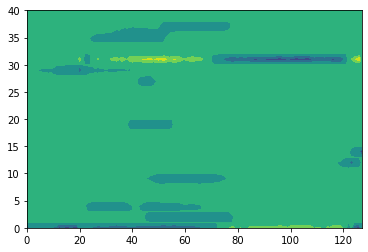

In [25]:
x = np.arange(0, grads.shape[0])
y = np.arange(0, grads.shape[1] - 1)
X, Y = np.meshgrid(x, y)
plt.contourf(X, Y, grads[:, :-1].T)

# Using an LSTM + classifier at every frame

In [26]:
criterion = CTCPhoneCriterion(encodedData.size(-1), n_phones, True, useLSTM=True)
# Omit the "5 layers" name, just for trials
criterionCP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/acpc-baseline-cosine/lineval_ctc_noblank_onenc_5layers_49/checkpoint_49.pt'
state_dict = torch.load(criterionCP, 'cpu')
criterion.load_state_dict(state_dict["cpcCriterion"])
ctcLogProbs, ctcLabel, targetSizePred, sizeLabels = criterion(cFeature[0], encodedData, label)
ctcLogProbs = ctcLogProbs.permute(1, 0, 2)
logSumExps = torch.logsumexp(ctcLogProbs, 2, keepdim=True)
ctcLogProbs = ctcLogProbs - logSumExps
ctcLogProbs = ctcLogProbs.detach().requires_grad_()
with torch.enable_grad():
    losses = F.ctc_loss(
        ctcLogProbs, 
        ctcLabel,
        targetSizePred,
        sizeLabels,
        reduction='none')
    losses = losses - logSumExps.squeeze(2).sum(0)
    losses.sum().backward()
    grads = ctcLogProbs.grad.detach()
    _, alignment = grads.min(-1)
grads = grads.squeeze()

In [27]:
predictedPhones, _ = collapseLabelChain(alignment.T)
print("Collapsed best alignment: ", predictedPhones)
print("Expected: ", ctcLabel)

Best alignment:  tensor([[ 0, 29, 31,  4, 35, 36, 19, 27,  4,  2,  9, 37,  2, 31, 12, 14]])
Expected:  tensor([[ 0, 29, 31,  4, 35, 36, 19, 27,  4,  2,  9, 37,  2, 31, 12, 14]])


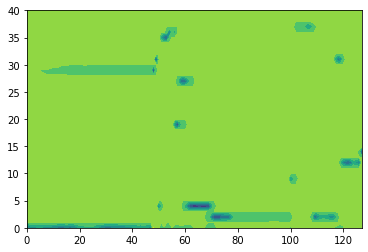

In [28]:
x = np.arange(0, grads.shape[0])
y = np.arange(0, grads.shape[1] - 1)
X, Y = np.meshgrid(x, y)
plt.contourf(X, Y, grads[:, :-1].T)

In [29]:
predictedPhones = alignment.T.detach().cpu()
phone_changes = torch.cat((torch.ones((predictedPhones.shape[0], 1), device=predictedPhones.device), torch.diff(predictedPhones, dim=1)), dim=1)
predictedBoundaries = torch.nonzero(phone_changes.contiguous().view(-1), as_tuple=True)[0]
predictedBoundaries

tensor([  0,  48,  49,  50,  51,  54,  56,  58,  61,  70, 100, 103, 109, 118,
        120, 127])

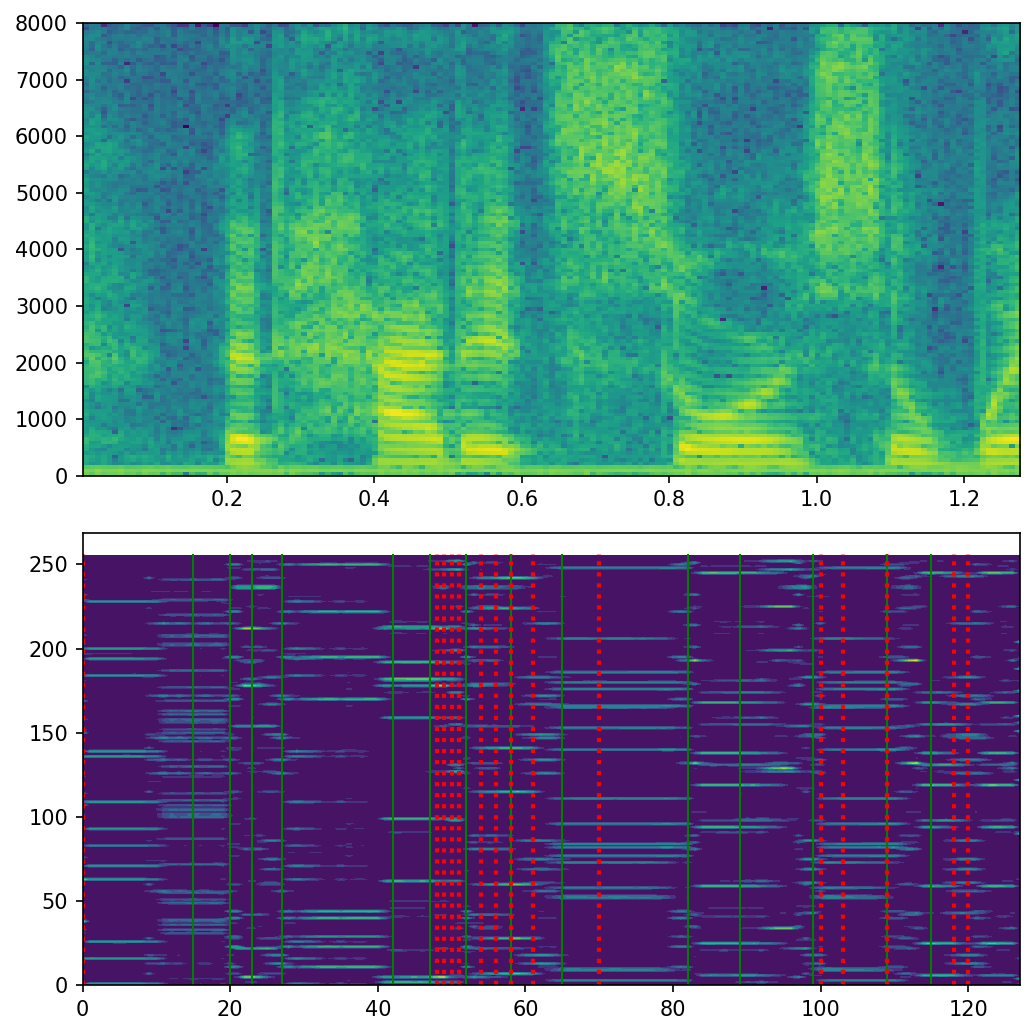

In [37]:
waveform = batchData.squeeze()
features = encodedData
enc = features[0, :None, :].detach().numpy()
enc = enc / np.sqrt((enc**2).sum(1, keepdims=True))
Z = enc.reshape(features.shape[1], features.shape[2]).T

plt.figure(figsize=(7, 7), dpi=150)
plt.subplot(211)
plt.specgram(waveform, Fs=16000)
plt.subplot(212)
x = np.arange(0, Z.shape[1])
y = np.arange(0, Z.shape[0])
X, Y = np.meshgrid(x, y)
plt.contourf(X, Y, Z, 10)
plt.vlines(x=trueBoundaries.numpy().tolist()[:-1], ymin=0, ymax=256, colors='g', linewidth=1)
plt.vlines(x=predictedBoundaries.numpy().tolist()[:-1], ymin=0, ymax=256, colors='r', linewidth=2, linestyles=':')
plt.xlim([0, 127])
plt.tight_layout()

# Using an LSTM + further downsampling with convolutional layer

In [38]:
criterion = CTCPhoneCriterion(encodedData.size(-1), n_phones, True, useLSTM=True, convClassifier=True)
# Omit the "5 layers" name, just for trials
criterionCP = '/pio/scratch/1/i323106/wav2vec/runs/cpc/acpc-baseline-cosine/lineval_ctc_noblank_onenc_49/checkpoint_9.pt'
state_dict = torch.load(criterionCP, 'cpu')
criterion.load_state_dict(state_dict["cpcCriterion"])
ctcLogProbs, ctcLabel, targetSizePred, sizeLabels = criterion(cFeature[0], encodedData, label)
ctcLogProbs = ctcLogProbs.permute(1, 0, 2)
logSumExps = torch.logsumexp(ctcLogProbs, 2, keepdim=True)
ctcLogProbs = ctcLogProbs - logSumExps
ctcLogProbs = ctcLogProbs.detach().requires_grad_()
with torch.enable_grad():
    losses = F.ctc_loss(
        ctcLogProbs, 
        ctcLabel,
        targetSizePred,
        sizeLabels,
        reduction='none')
    losses = losses - logSumExps.squeeze(2).sum(0)
    losses.sum().backward()
    grads = ctcLogProbs.grad.detach()
    _, alignment = grads.min(-1)
grads = grads.squeeze()

/pio/scratch/1/i323106/miniconda3/envs/cpc37/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


In [39]:
predictedPhones, _ = collapseLabelChain(alignment.T)
print("Collapsed best alignment: ", predictedPhones)
print("Expected: ", ctcLabel)

Best alignment:  tensor([[ 0, 29, 31,  4, 35, 36, 19, 27,  4,  2,  9, 37,  2, 31, 12, 14]])
Expected:  tensor([[ 0, 29, 31,  4, 35, 36, 19, 27,  4,  2,  9, 37,  2, 31, 12, 14]])


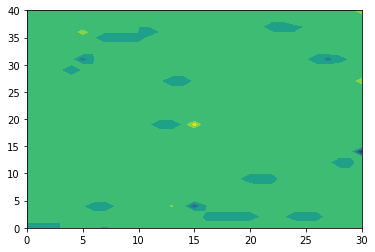

In [40]:
x = np.arange(0, grads.shape[0])
y = np.arange(0, grads.shape[1] - 1)
X, Y = np.meshgrid(x, y)
plt.contourf(X, Y, grads[:, :-1].T)

In [45]:
len(ctcLogProbs)

31

In [48]:
downsamplingFactor = 20480 / len(ctcLogProbs)
samplingRate = 16e3 / downsamplingFactor

predictedPhones = alignment.T.detach().cpu()
phone_changes = torch.cat((torch.ones((predictedPhones.shape[0], 1), device=predictedPhones.device), torch.diff(predictedPhones, dim=1)), dim=1)
predictedBoundaries = torch.nonzero(phone_changes.contiguous().view(-1), as_tuple=True)[0]
predictedBoundaries = predictedBoundaries / samplingRate * 100
predictedBoundaries

tensor([  0.0000,  16.5161,  20.6452,  24.7742,  33.0323,  45.4194,  49.5484,
         57.8064,  61.9355,  66.0645,  82.5806,  90.8387,  99.0968, 111.4839,
        115.6129, 123.8710])

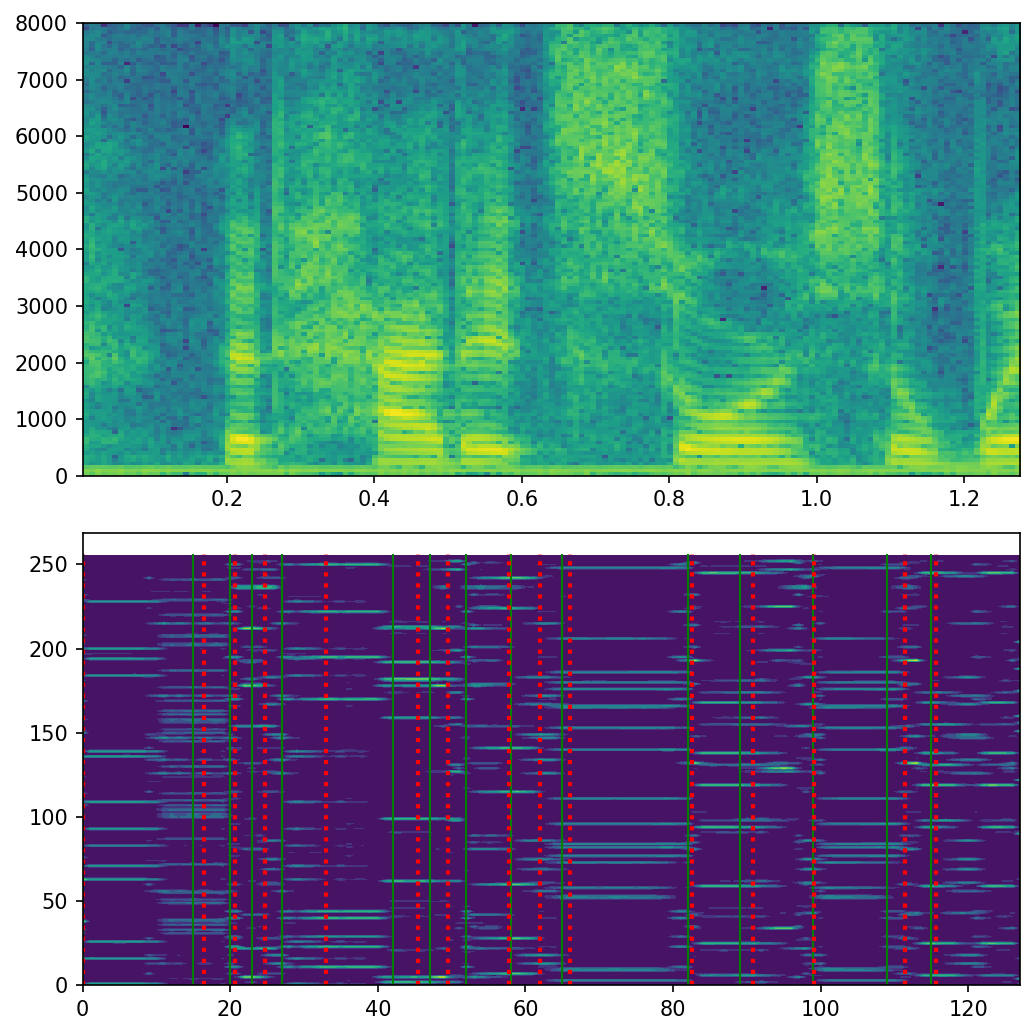

In [49]:
waveform = batchData.squeeze()
features = encodedData
enc = features[0, :None, :].detach().numpy()
enc = enc / np.sqrt((enc**2).sum(1, keepdims=True))
Z = enc.reshape(features.shape[1], features.shape[2]).T

plt.figure(figsize=(7, 7), dpi=150)
plt.subplot(211)
plt.specgram(waveform, Fs=16000)
plt.subplot(212)
x = np.arange(0, Z.shape[1])
y = np.arange(0, Z.shape[0])
X, Y = np.meshgrid(x, y)
plt.contourf(X, Y, Z, 10)
plt.vlines(x=trueBoundaries.numpy().tolist()[:-1], ymin=0, ymax=256, colors='g', linewidth=1)
plt.vlines(x=predictedBoundaries.numpy().tolist()[:-1], ymin=0, ymax=256, colors='r', linewidth=2, linestyles=':')
plt.xlim([0, 127])
plt.tight_layout()